# Distance of AOI vs t-test

This notebook analyzes the relationship between the distance of an Area of Interest (AOI) from a central point and the statistical significance of temperature differences using t-tests. It compares two simulation scenarios (Baseline and Scenario 1) across various AOIs and increasing buffer distances, evaluating whether the observed temperature differences are statistically significant at different spatial scales.

## 1. Import dependencies

This section imports all necessary libraries for data manipulation, netCDF file handling, geographical data processing, statistical analysis, and visualization.

In [ ]:
import os

import numpy as np
import netCDF4 as nc
from IPython.display import display
import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import geopandas as gpd
import pandas as pd
from scipy import stats

from utils import palm_variables

## 2. Import data
This section defines the file paths for the simulation output and static driver files, then reads them into netCDF4 datasets. It also extracts 2D building data for later use in masking.

In [ ]:
# Absolute URL of simulation output files and static driver
file_xy_1 = r"./Data/_simulation_outputs_3/konstanz_4096x4096_v9_Baseline-48hr/OUTPUT/konstanz_4096x4096_v9_Baseline_av_xy_N03.000.nc"
file_xy_2 = r"./Data/_simulation_outputs_3/konstanz_4096x4096_v9_Scenario_1-48hr/OUTPUT/konstanz_4096x4096_v9_Scenario_1_av_xy_N03.000.nc"
file_static = r"./Data/_simulation_outputs_3/konstanz_4096x4096_v9_Scenario_1-48hr/INPUT/konstanz_4096x4096_v9_Scenario_1_static_N03"

# Read netCDF files into dataset objects
dataset_1 = nc.Dataset(file_xy_1, mode='r')
dataset_2 = nc.Dataset(file_xy_2, mode='r')
dataset_3 = nc.Dataset(file_static, mode='r')

# Store datasets in a list for easier iteration
dataset_list = [dataset_1, dataset_2]

# Extract 2D building data from the static driver file
buildings_2d = dataset_3['buildings_2d']
buildings_2d_data = buildings_2d[:,:]

## 3. Variable Selection
This section allows the user to select a test variable from the available PALM simulation output. The selected variable's description and unit are displayed for clarity.

In [ ]:
# Get all variable names from the first dataset
var_names = dataset_1.variables.keys()

# Filter for 3D variables (variables with more than 2 dimensions, typically time, height, y, x)
var_names_palm = [var for var in var_names if dataset_1.variables[var].ndim > 2]

# Initialize test_variable with the first suitable variable
test_variable = var_names_palm[0]

# Initialize dropdown widget for variable selection
drop_down = widgets.Dropdown(options=var_names_palm,
                             value=var_names_palm[0],
                             description='Select test variable:'
                             )

# Handler function to update the global test_variable when dropdown value changes
def dropdown_handler(change):
    global test_variable
    print(change.new)
    test_variable = change.new
    print(f"Selected variable: {test_variable}")

# Observe changes in the dropdown's value
drop_down.observe(dropdown_handler, names='value')

# Display the dropdown widget
display(drop_down)

Dropdown(description='Select test variable:', options=('ta_2m*_xy', 'tsurf*_xy', 'wspeed_10m*_xy', 'bio_pet*_x…

In [ ]:
# Check if the test variable contains a wildcard, indicating it might be a generic variable type
if "*" in test_variable:
    # Extract the base name of the variable (e.g., 'T' from 'T*')
    var_initial = ((test_variable.split("*"))[0]) + "*"
    # Get the unit and description from the palm_variables dictionary
    unit = palm_variables.variables_dict[var_initial]['unit']
    description = palm_variables.variables_dict[var_initial]['description']
    # Print the capitalized description and unit
    print(f"{description.capitalize()}, {unit}")

2-m air temperature, °C


## 4. Define time sequence and time equivalent
This section prepares time-related data for the analysis, defining time steps and functions to convert them into human-readable hourly equivalents.

In [ ]:
# Extract data for the selected test variable from the first dataset
variable_data_1 = dataset_1[test_variable]

# Get the shape of the variable data, specifically the number of time steps
variable_data_shape = np.shape(variable_data_1)
total_time_steps = variable_data_shape[0]

# Display the total number of time steps
total_time_steps

288

In [ ]:
# Define parameters for time step intervals and the starting second step
time_step_interval = 6  # Represents 1 hour (6 * 10 minutes = 60 minutes)
second_step = 5         # Corresponds to 1:00 hour mark in the 6-step interval (0:00, 0:10, ..., 0:50, 1:00)

# Create a time sequence for hourly intervals
time_sequence_hourly = [0]
time_sequence_hourly.extend(np.arange(second_step, total_time_steps, time_step_interval))

# Create a time sequence for all time steps
time_sequence_all = range(total_time_steps)

def get_time_equivalent(time_sequence):
    """
    Converts a sequence of time steps (each representing 10 minutes) into
    human-readable HH:MM format.

    Args:
        time_sequence (list or array): A list of time step indices.

    Returns:
        tuple: A tuple containing:
            - time_equivalent (list): List of time strings in HH:MM format (can exceed 24 hours).
            - time_equivalent_24hr (list): List of time strings in 24-hour HH:MM format (resets after 23:50).
    """
    time_equivalent = []
    time_equivalent_24hr = []
    
    for time_step in time_sequence:
        total_minutes = (time_step + 1) * 10
        hours, minutes = divmod(total_minutes, 60)
        
        # Append time equivalent in hours:minutes format
        time_equivalent.append(f"{hours:02d}:{minutes:02d}")
        
        # Handle overflow of hours for 24-hour format (e.g., 25:00 becomes 01:00)
        hours_24hr = hours % 24
        time_equivalent_24hr.append(f"{hours_24hr:02d}:{minutes:02d}")
    
    return time_equivalent, time_equivalent_24hr

# Generate time equivalents for hourly and all time steps
time_equivalent_hourly, time_equivalent_hourly_24hr = get_time_equivalent(time_sequence_hourly)
time_equivalent_all, time_equivalent_all_24hr = get_time_equivalent(time_sequence_all)

## 5. Define codes useful for future
This section defines essential grid and coordinate system parameters from the dataset, which are crucial for spatial operations and data extraction in subsequent steps.

In [ ]:
# Define grid spacing (dx, dy)
dx = dataset_1['x'][1] - dataset_1['x'][0]
dy = dataset_1['y'][1] - dataset_1['y'][0]

# Define number of cells in x and y dimensions
nx = np.shape(dataset_1['x'])[0]
ny = np.shape(dataset_1['y'])[0]

# Coordinates of the origin in PALM (x, y, z)
origin_x, origin_y, origin_z = dataset_1.origin_x, dataset_1.origin_y, dataset_1.origin_z

# Vectors for coordinate at cell edges (x, y)
x = np.arange(nx + 1) * dx + origin_x
y = np.arange(ny + 1) * dy + origin_y  # Corrected to use ny for y-axis

# Vectors for coordinates at cell centers (xc, yc)
xc = np.arange(nx) * dx + origin_x + dx / 2
yc = np.arange(ny) * dy + origin_y + dy / 2  # Corrected to use ny for y-axis

# Time-related information
origin_time = dataset_1.origin_time 
time_step = 600  # Default time step in seconds (from dataset_1.time_step, if available)
nt = np.shape(dataset_1['time'])[0]  # Total number of time steps

# Print key grid and time parameters
print(f"Number of cells (nx, ny): {nx}, {ny}")
print(f"Origin coordinates (x, y, z): {origin_x}, {origin_y}, {origin_z}")
print(f"Origin time: {origin_time}")
print(f"Total number of time steps (nt): {nt}")

Number of cells (nx, ny): 256, 256
Origin coordinates (x, y, z): 512902.0, 5278402.0, 392.87999725341797
Origin time: 2023-06-13 23:00:00 +00
Total number of time steps (nt): 288


In [ ]:
def get_extents(gdf_combined, location_id, increased_distance):
    """
    Calculates the array indices (extents) for a given geographical polygon (AOI)
    with an optional buffer distance.

    Args:
        gdf_combined (geopandas.GeoDataFrame): GeoDataFrame containing all AOI polygons.
        location_id (int): Index of the specific AOI in gdf_combined.
        increased_distance (int): The buffer distance in grid cells to expand the AOI.

    Returns:
        tuple: A tuple (x_low, y_low, x_high, y_high) representing the array indices
               of the bounding box for the buffered AOI, clamped to the simulation domain boundaries.
    """
    # Extract the polygon geometry for the given location ID
    polygon_aug = gdf_combined.iloc[location_id]
    polygon = polygon_aug.geometry
    min_x, min_y, max_x, max_y = polygon.bounds

    # Convert geographic coordinates to array indices (assuming dx = dy)
    x1 = int((min_x - origin_x) / dx)
    y1 = int((min_y - origin_y) / dx)
    x2 = int((max_x - origin_x) / dx)
    y2 = int((max_y - origin_y) / dx)

    # Calculate half-window for the increased distance
    half_window = int(increased_distance / 2)

    # Apply the buffer to the extents
    x_low, x_high = x1 - half_window, x2 + half_window
    y_low, y_high = y1 - half_window, y2 + half_window

    # Clamp the extents to the simulation domain boundaries (0 to nx/ny)
    x_low = max(0, x_low)
    y_low = max(0, y_low)
    x_high = min(nx, x_high)  # Use nx for x_high boundary
    y_high = min(ny, y_high)  # Use ny for y_high boundary

    return (x_low, y_low, x_high, y_high)

## 6. Extract variable data and select domain
This section loads variable data from both simulation scenarios and reads shapefiles defining Areas of Interest (AOIs). These AOIs will be used to extract relevant data subsets for statistical analysis.

In [ ]:
# Load variable data for the selected test variable from both datasets
variable_data_1 = dataset_1[test_variable]
variable_data_2 = dataset_2[test_variable]
variable_datas = [variable_data_1, variable_data_2]

# Define scenario names for labeling
sim_scenarions = ['Baseline (BS)', 'Scenario 1 (S1)']
sim_scene = ['BS', 'S1']

# Define paths to shapefiles for different AOI definitions
shapefile_path_child_ii = r"./Data/shapefiles/03_AOI_Child_II.shp"
shapefile_path_uhi_study = r"./Data/shapefiles/UHI_aoi_study_fitted.shp"

# Read shapefiles into GeoDataFrames
gdf_child = gpd.read_file(shapefile_path_child_ii)
gdf_uhi = gpd.read_file(shapefile_path_uhi_study)

# Combine the GeoDataFrames for easier indexing of all AOIs
gdf_combined = gpd.pd.concat([gdf_child, gdf_uhi], ignore_index=True)

# Define a list of location names corresponding to the combined AOIs
location_name_list = ['Overall', 'Stephansplatz', 'Markstaette', 'Augustinerplatz']

## 7. Define time steps to generate aggregated values
The get_aggregate_time_list function creates lists of time steps for aggregation. This allows for calculating statistics over a moving window of time, providing a smoothed perspective on the data.

In [ ]:
def get_aggregate_time_list(total_time_steps, aggregate_time_steps):
    """
    Generates a list of time step ranges for aggregation, creating a moving window.

    Args:
        total_time_steps (int): Total number of time steps in the simulation.
        aggregate_time_steps (int): The size of the aggregation window (number of time steps).

    Returns:
        list: A list where each element is a sub-list of time step indices
              representing an aggregation window.
    """
    time_lists = []
    
    for i in range(total_time_steps):
        if aggregate_time_steps <= 1:
            time_list = [i]
        else:
            # Calculate half-window for even and odd aggregation sizes
            half_window = aggregate_time_steps // 2
            if aggregate_time_steps % 2 == 0:
                # For even window, window is centered around current step 'i'
                time_list = [j for j in range(i - half_window, i + half_window)]
            else:
                # For odd window, window is centered around current step 'i'
                time_list = [j for j in range(i - half_window, i + half_window + 1)]
        
        # Ensure indices are within bounds (0 to total_time_steps - 1)
        valid_time_list = [j for j in time_list if 0 <= j < total_time_steps]
        time_lists.append(valid_time_list)
    
    return time_lists

In [ ]:
# Define the number of time steps to aggregate for the moving average (e.g., 6 steps = 1 hour)
aggregate_time_steps = 6

# Generate the list of aggregated time step windows
time_lists = get_aggregate_time_list(total_time_steps, aggregate_time_steps)

# Optional: Uncomment to view the generated time lists
# time_lists

## 8. Create dataframe for statistics
This section defines a function create_aggregated_dataframe that performs t-tests between the two simulation scenarios (Baseline and Scenario 1) for a specified AOI and varying buffer distances. It returns a DataFrame containing p-values for each time step and buffer distance.

In [ ]:
def create_aggregated_dataframe(location_id, increased_distances):
    """
    Performs t-tests between two simulation datasets for a given AOI
    at various increased buffer distances.

    Args:
        location_id (int): The index of the AOI in `gdf_combined`.
        increased_distances (list): A list of buffer distances (in grid cells) to apply around the AOI.

    Returns:
        pandas.DataFrame: A DataFrame containing time steps, time equivalents,
                          alpha value, and p-values for each increased distance.
    """
    # Read polygon extends from the shapefile based on location id
    polygon_aug = gdf_combined.iloc[location_id]
    polygon = polygon_aug.geometry
    min_x, min_y, max_x, max_y = polygon.bounds

    # Convert geographic coordinates to array indices
    x1 = int((min_x - origin_x) / dx)
    y1 = int((min_y - origin_y) / dy)
    x2 = int((max_x - origin_x) / dx)
    y2 = int((max_y - origin_y) / dy)
    
    # Define significance level (alpha)
    alpha = 0.05
    
    # Dictionaries to store t-statistics and p-values
    t_statistics_dict, p_values_dict = {}, {}

    for i in increased_distances:
        half_window = int(i / 2)
        x_low, x_high = x1 - half_window, x2 + half_window
        y_low, y_high = y1 - half_window, y2 + half_window
        
        # Clamp coordinates to simulation domain boundaries
        x_low = max(0, x_low)
        y_low = max(0, y_low)
        x_high = min(nx, x_high)
        y_high = min(ny, y_high)

        t_statistics, p_values_ttest = [], []
        for time_list in time_lists:
            values_real_1 = []
            values_real_2 = []
            
            for time_index in time_list:
                # Extract values for each time_index and remove masked values (e.g., buildings)
                values_time_index_1 = variable_data_1[time_index, 0, y_low:y_high, x_low:x_high]
                values_time_index_2 = variable_data_2[time_index, 0, y_low:y_high, x_low:x_high]
                
                # Apply building mask (assuming ~buildings_2d_data.mask inverts the mask correctly)
                values_time_index_1.mask = ~buildings_2d_data.mask
                values_time_index_2.mask = ~buildings_2d_data.mask
                
                # Get compressed (unmasked) values
                values_time_index_real_1 = values_time_index_1.compressed()
                values_time_index_real_2 = values_time_index_2.compressed()
                
                # Extend real values to lists
                values_real_1.extend(values_time_index_real_1)
                values_real_2.extend(values_time_index_real_2)

            # Perform independent t-test
            t_statistic, p_value_ttest = stats.ttest_ind(values_real_1, values_real_2)
            
            # Append t-statistic and p-value to lists, formatted to scientific notation
            t_statistics.append(t_statistic)
            p_values_ttest.append(p_value_ttest)
        
        # Add results to dictionaries with formatted string values
        t_statistics_dict[f't-statistics_{i}'] = [f"{t:.3e}" for t in t_statistics]
        p_values_dict[f'p-value_{i}'] = [f"{p:.3e}" for p in p_values_ttest]

    # Create the base DataFrame data
    df_data = {
        'Time step': time_sequence_all,
        'Time (hr)': time_equivalent_all,
        'alpha': f"{alpha:.2f}"
    }
    
    # Add p-values to DataFrame data
    df_data.update(p_values_dict)

    # Create the final DataFrame
    df = pd.DataFrame(df_data)
    return df

In [ ]:
# Define the list of increased distances (buffer sizes in grid cells)
increased_distances = list(range(0, 31, 2))
print(f"Increased distances (in grid cells): {increased_distances}")

# Define the number of time steps to aggregate (e.g., 6 steps = 1 hour)
aggregate_time_steps = 6
time_lists = get_aggregate_time_list(total_time_steps, aggregate_time_steps)

# Output folder and base file name
output_dir = "./output/02_csv"
os.makedirs(output_dir, exist_ok=True)
base_filename = f"02_agg_{aggregate_time_steps}steps_df_"

# Function to load or create and save DataFrame
def get_or_create_df(location_id):
    csv_path = os.path.join(output_dir, f"{base_filename}{location_id}.csv")
    if os.path.exists(csv_path):
        print(f"Loading existing DataFrame for location_id={location_id} from {csv_path}")
        df = pd.read_csv(csv_path)
    else:
        print(f"Creating new DataFrame for location_id={location_id}")
        df = create_aggregated_dataframe(location_id=location_id, increased_distances=increased_distances)
        df.to_csv(csv_path, index=False)
        print(f"Saved DataFrame to {csv_path}")
    return df

# Get or create DataFrames for each location ID
df_0 = get_or_create_df(0)
df_1 = get_or_create_df(1)
df_2 = get_or_create_df(2)
df_3 = get_or_create_df(3)

Increased distances (in grid cells): [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
Creating new DataFrame for location_id=0
Saved DataFrame to ./output/02_csv\02_agg_6steps_df_0.csv
Creating new DataFrame for location_id=1
Saved DataFrame to ./output/02_csv\02_agg_6steps_df_1.csv
Creating new DataFrame for location_id=2
Saved DataFrame to ./output/02_csv\02_agg_6steps_df_2.csv
Creating new DataFrame for location_id=3
Saved DataFrame to ./output/02_csv\02_agg_6steps_df_3.csv


## 9. Define function to create counts dataframe
The counts_df function processes the p-value DataFrames to count instances where the null hypothesis (no significant difference) is either rejected or failed to be rejected, based on the specified alpha level.

In [ ]:
def counts_df(df):
    """
    Processes a DataFrame containing p-values and calculates the counts
    of rejected and failed-to-reject null hypotheses for each distance.

    Args:
        df (pandas.DataFrame): The input DataFrame with 'p-value_X' columns
                               and an 'alpha' column.

    Returns:
        pandas.DataFrame: A DataFrame summarizing the counts for each distance.
    """
    counts = []

    for i in increased_distances:
        col_name = f'p-value_{i}'

        # Count instances where p-value is less than alpha (Reject Null Hypothesis)
        count_less_than_alpha = (df[col_name].astype(float) < df['alpha'].astype(float)).sum()
        
        # Count instances where p-value is greater than alpha (Fail to Reject Null Hypothesis)
        count_greater_than_alpha = (df[col_name].astype(float) > df['alpha'].astype(float)).sum()

        counts.append({'distance': i,
                       'count_less_than_alpha': count_less_than_alpha,
                       'count_greater_than_alpha': count_greater_than_alpha,
                       'Reject Null': count_less_than_alpha,
                       'Fail to reject null': count_greater_than_alpha})

    # Create a DataFrame from the collected counts
    counts_df = pd.DataFrame(counts)
    return counts_df

In [ ]:
# Define the end step for slicing the counts DataFrames
end_step = 20

# Calculate counts for each AOI and slice them up to the 'end_step'
counts_df_0 = counts_df(df_0)[:end_step]
counts_df_1 = counts_df(df_1)[:end_step]
counts_df_2 = counts_df(df_2)[:end_step]
counts_df_3 = counts_df(df_3)[:end_step]

# Extract the row corresponding to the 5th increased_distance (index 5) for each counts DataFrame
row_0 = counts_df_0.iloc[5]
row_1 = counts_df_1.iloc[5]
row_2 = counts_df_2.iloc[5]
row_3 = counts_df_3.iloc[5]

# Create a new DataFrame by concatenating the extracted rows
new_df = pd.DataFrame({'counts_df_0': row_0, 'counts_df_1': row_1, 'counts_df_2': row_2, 'counts_df_3': row_3})

# Transpose the DataFrame and add a 'location' column for clarity
ttest_counts_df = new_df.T
ttest_counts_df['location'] = ['Overall', 'Stephansplatz', 'Markstaette', 'Augustinerplatz']

# Display the resulting DataFrame
ttest_counts_df

,distance,count_less_than_alpha,count_greater_than_alpha,Reject Null,Fail to reject null,location
counts_df_0,10,275,13,275,13,Overall
counts_df_1,10,260,28,260,28,Stephansplatz
counts_df_2,10,254,34,254,34,Markstaette
counts_df_3,10,269,19,269,19,Augustinerplatz


## 10. Plotting the bar graph
This section generates a bar graph to visualize the number of time instances where the null hypothesis was either rejected or failed to be rejected for different AOIs.

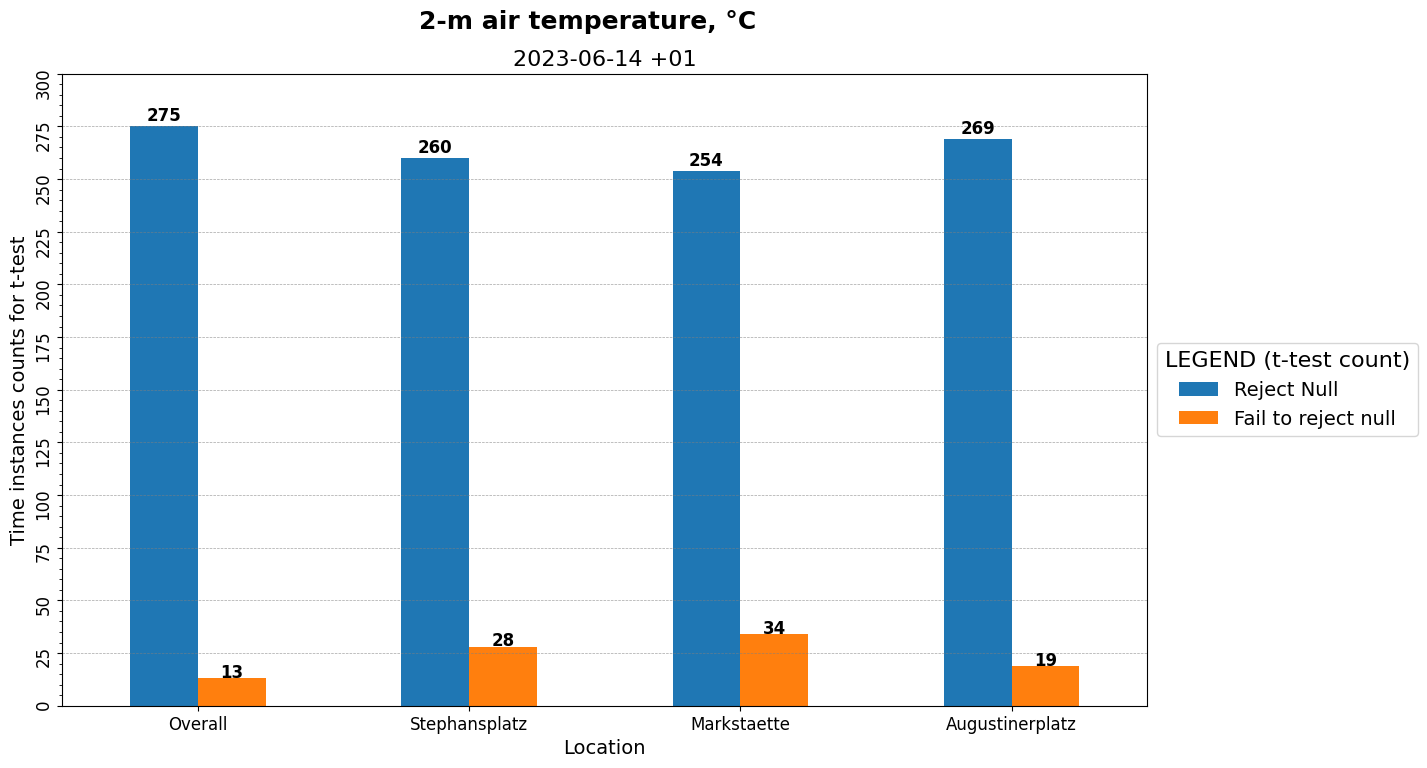

In [ ]:
# Create a figure and an axes object for the plot
fig, ax = plt.subplots(figsize=(14, 8), facecolor='w', edgecolor='k')

# Set the main title of the plot, including the variable description and unit
plt.suptitle(f"{description}, {unit}", fontsize=18, weight='bold')

# Set the subplot title for the specific time instance (2023-06-14 +01)
ax.set_title(f'2023-06-14 +01', fontsize=16)

# Adjust subplot parameters for a tight layout
plt.subplots_adjust(top=0.90)

# Plot the 'Reject Null' and 'Fail to reject null' counts as a bar graph
ttest_counts_df.set_index('location').plot(kind='bar', y=['Reject Null', 'Fail to reject null'], stacked=False, ax=ax)

# Set labels for the x and y axes
ax.set_xlabel('Location', fontsize=14)
ax.set_ylabel('Time instances counts for t-test', fontsize=14)

# Add value labels on top of the bars for easy interpretation
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height * 1.01), 
                ha='center', fontsize=12, weight='bold')

# Configure grid lines, ticks, and tick labels for the y-axis
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax.tick_params(axis='x', labelsize=12, rotation=0) # Rotate x-axis labels horizontally
ax.tick_params(axis='y', labelsize=12, rotation=90) # Rotate y-axis labels vertically

# Set major and minor ticks for the y-axis
ax.yaxis.set_ticks(np.arange(0, 301, 25))
minor_locator = MultipleLocator(5) # Minor ticks every 5 units
ax.yaxis.set_minor_locator(minor_locator)

# Add a legend to the plot, positioned outside the plot area
ax.legend(title=f"LEGEND (t-test count)",
          title_fontsize=16,
          fontsize=14,
          bbox_to_anchor=(1, 0.5),
          loc='center left')

# Display the plot
plt.show()

## 11. Plot line graph
This section generates a line graph to visualize the number of times the null hypothesis was rejected (indicating a significant difference) across various buffer distances for each AOI. Trend lines are added for better interpretation of the spatial patterns.

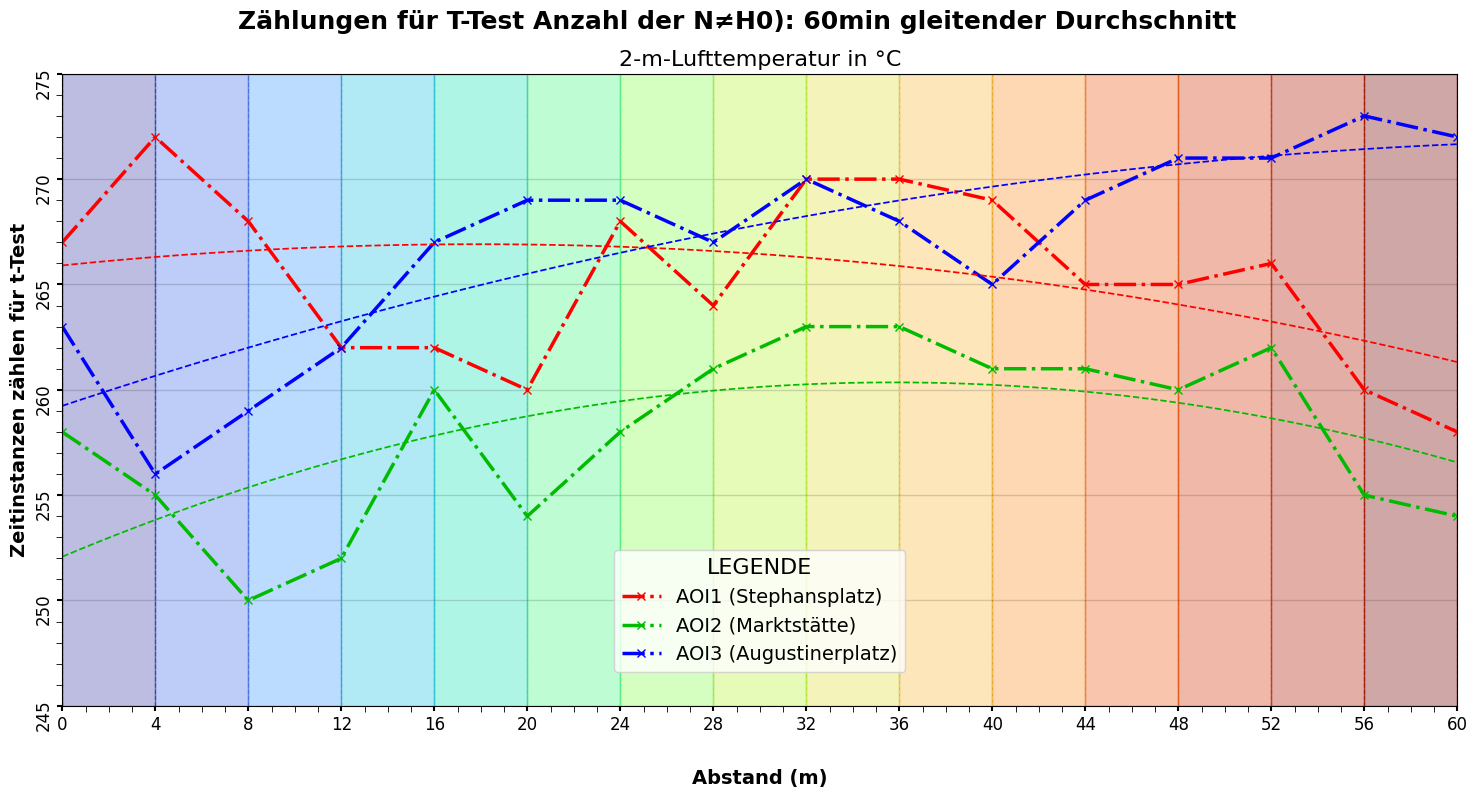

Null Hypothesis: No significant difference


In [ ]:
# Create a figure and an axes object for the plot
fig, ax = plt.subplots(figsize=(18, 8), facecolor='w', edgecolor='k')

# Set the main title of the plot based on aggregation time steps
if aggregate_time_steps <= 1:
    plt.suptitle(f"Zählungen für T-Test (Anzahl der N≠H0)", fontsize=18, weight='bold')
else:
    plt.suptitle(f"Zählungen für T-Test Anzahl der N≠H0): {10*aggregate_time_steps}min gleitender Durchschnitt", fontsize=18, weight='bold')

# Set the subplot title with the variable unit
ax.set_title(f"2-m-Lufttemperatur in {unit}", fontsize=16)

# Adjust subplot parameters for a tight layout
plt.subplots_adjust(top=0.90)

# Configure grid lines and tick parameter styles for both axes
ax.grid(which='major', axis='both', linestyle='-', linewidth=1, color='#00000050', alpha=0.15)
ax.tick_params(axis='x', labelsize=12, rotation=0, width=1.5)
ax.tick_params(axis='y', labelsize=12, rotation=90, width=1.5)

# Set x and y axis labels
ax.set_xlabel("Abstand (m)", fontsize=14, weight='bold')
ax.xaxis.set_label_coords(0.5, -0.1) # Adjust x-axis label position
ax.set_ylabel("Zeitinstanzen zählen für t-Test", fontsize=14, weight='bold')

# Set x-axis ticks and limits
ax.set_xticks(counts_df_1['distance'])
ax.set_xlim(-0.5, 30.5) 

# Adjust x-tick labels to represent actual distances in meters (assuming multiplier of 2 for grid cells to meters)
current_xticks = counts_df_1['distance']
multiplier = 2  # Assuming 1 grid cell = 2 meters based on typical PALM dx/dy
new_xticks = current_xticks * multiplier
new_xtick_labels = [str(x) for x in new_xticks]
ax.set_xticks(current_xticks)
ax.set_xticklabels(new_xtick_labels)

# Draw vertical lines and spans to visually represent distance intervals
cmap = matplotlib.colormaps['turbo'] # Colormap for visual differentiation
values = np.linspace(0, 1, 16) # Values to sample the colormap
rgba_colors = cmap(values) # RGBA colors from the colormap

for i in range(len(counts_df_0)):
    ax.axvline(x=i*2, color=rgba_colors[i], linestyle='--', linewidth=0.85)
    ax.axvspan((i-1)*2, i*2, alpha=0.35, color=rgba_colors[i])

# Set y-axis ticks and limits
ax.set_yticks(range(245, 276, 5))
ax.set_ylim(245, 275)
ax.set_xlim(0, 60/2)

# Enable and configure minor ticks for the y-axis
ax.minorticks_on()
minor_locator = MultipleLocator(1)  # Minor ticks every 1 unit
ax.yaxis.set_minor_locator(minor_locator)
ax.tick_params(which='minor', length=4)  # Customizing minor ticks' appearance

# Plot the 'count_less_than_alpha' for each AOI
line1, = ax.plot(counts_df_1['distance'],
                 counts_df_1['count_less_than_alpha'].astype(float),
                 color='#ff0000',
                 linestyle='-.',
                 marker='x',
                 label='AOI1 (Stephansplatz)',
                 linewidth=2.5)
line2, = ax.plot(counts_df_2['distance'],
                 counts_df_2['count_less_than_alpha'].astype(float),
                 color='#00bb00',
                 linestyle='-.',
                 marker='x',
                 label='AOI2 (Marktstätte)',
                 linewidth=2.5)
line3, = plt.plot(counts_df_3['distance'],
                  counts_df_3['count_less_than_alpha'].astype(float),
                  color='#0000ff',
                  linestyle='-.',
                  marker='x',
                  label='AOI3 (Augustinerplatz)',
                  linewidth=2.5)

# Add curved trend lines using polynomial fitting
for df, color in zip([counts_df_1, counts_df_2, counts_df_3],
                     ['#ff0000', '#00bb00', '#0000ff']):
    z = np.polyfit(df['distance'], df['count_less_than_alpha'], 2)  # Fit a quadratic polynomial
    p = np.poly1d(z) # Create a polynomial function
    x_smooth = np.linspace(min(df['distance']), max(df['distance']), 100)  # Generate points for a smooth curve
    ax.plot(x_smooth, p(x_smooth), color=color, linestyle='--', linewidth=1.25) # Plot the smooth curve

# Add a legend to the plot
ax.legend(handles=[line1, line2, line3],
          title="LEGENDE",
          title_fontsize=16,
          fontsize=14,
          bbox_to_anchor=(0.5, 0.15),
          loc='center')

# Display the plot
plt.show()

# Print the null hypothesis statement for context
print("Null Hypothesis: No significant difference")